In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install pyenchant
# !apt-get install libenchant1c2a

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Cleaning

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.callbacks import History
import os

# os.chdir('/content/drive/MyDrive/NeuralResearch/wine-net/')

# os.chdir('/content/drive/MyDrive/MSCA_31009/Final_Project/')

def remove_punctuation(s):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

  # Removing punctuations in string
  # Using loop + punctuation string
    for ele in s:
        if ele in punc:
            s = s.replace(ele, "")
    return s

def clean_description(review, swap):
    terms = review.split()
    for x in terms:
        try: x = swap[('t_' + str(x))]
        except KeyError: x = ''
    return ' '.join(terms)


In [4]:
wines = pd.read_csv('winemag-data-130k-v2.csv')
wines = wines.drop(columns = ['Unnamed: 0'])

wines2 = pd.read_csv('winemag-data_first150k.csv')
wines2.head()

# Intersect and append two review tables
columns = [value for value in wines.columns if value in wines2.columns] # intersection(wines.columns, wines2.columns)
wines = wines[columns]
wines2 = wines2[columns]
wines = pd.concat([wines, wines2]).drop(columns = ['designation', 'winery'])

#Try to group similar wines together
#red vs white
#less categories

wines = wines.sample(n=100000)

# Actual wines
var = list(wines.variety.value_counts()[wines.variety.value_counts() > 3000].index)
wines = wines[wines.variety.isin(var)]

# Imputation steps
median_price = wines.price.median()
median_points = wines.points.median()

# Impute variables
wines.price = wines.price.fillna(median_price)
wines.points = wines.points.fillna(median_points)
wines = wines.fillna('')
wines.price = wines.price.astype(int)
wines.description = wines.description.apply(lambda x: remove_punctuation(x.lower()))

# Data Preparation

In [5]:
#Wine Price Regression
Y_price = wines.price

#Wine Points Classification
Y_points = wines.points.apply(lambda x: 1 if x > 87 else 0)


#Wine Color Classification
Y_red_white = [0 if wines['variety'].iloc[x] in ['Pinot Noir','Cabernet Sauvignon','Red Blend','Bordeaux-style Red Blend','Syrah','Merlot'] else 1 for x in range(len(wines['variety']))]
Y_red_white = pd.Series(Y_red_white)
output_shape_red_white = Y_red_white.nunique()


#Wine Variety Type Classification
# encode class values as integers

Y = wines.variety
output_shape_variety_types = Y.nunique()

encoder = LabelEncoder()

encoder.fit(Y)
Y_variety_types = encoder.transform(Y)

# Y = Y.to_numpy()
# Y

# wines_dict = {'Pinot Noir': 1, 
#                 'Chardonnay':2,
#                 'Cabernet Sauvignon':3,
#                 'Red Blend':4,
#                 'Bordeaux-style Red Blend':5,
#                 'Sauvignon Blanc':6,
#                 'Riesling':7,
#                 'Syrah':8}

# Y_variety_types=[]
# for x in wines['variety']:
#     Y_variety_types.append(wines_dict[x])
# Y_variety_types = pd.Series(Y_variety_types)
# output_shape_variety_types = len(wines_dict)

#### Price Value Counts

In [6]:
Y_price.value_counts()

29     3858
20     2476
25     2152
30     2027
15     1978
       ... 
625       1
388       1
154       1
411       1
445       1
Name: price, Length: 293, dtype: int64

#### Points Value Counts & Distribution

In [7]:
Y_points.value_counts()

1    30080
0    20241
Name: points, dtype: int64

C:\Users\223055302\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='points', ylabel='Density'>

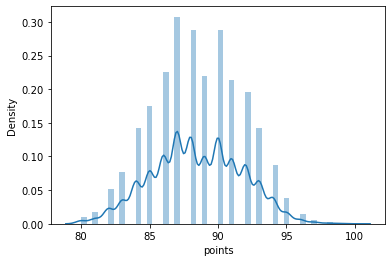

In [8]:
#Distribution of Points Scale 0-100
sns.distplot(wines.points)

C:\Users\223055302\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='points', ylabel='Density'>

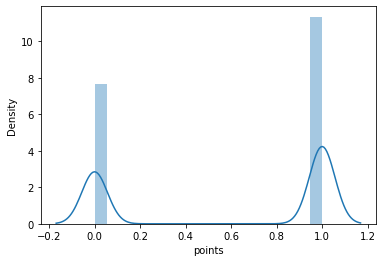

In [9]:
#Distribution of Points <=87 = 0
#                Points > 87 = 1
sns.distplot(Y_points)

#### Red & White Value Counts

In [10]:
Y_red_white.value_counts()

0    33157
1    17164
dtype: int64

#### Wine Variety Value Counts

In [11]:
# Original Data Distribution
print(wines.variety.value_counts())

Pinot Noir                  9848
Chardonnay                  9246
Cabernet Sauvignon          7894
Red Blend                   6764
Bordeaux-style Red Blend    5063
Sauvignon Blanc             4065
Riesling                    3853
Syrah                       3588
Name: variety, dtype: int64


In [12]:
#Y_variety_types Data Distribution
np.bincount(Y_variety_types)

array([5063, 7894, 9246, 9848, 6764, 3853, 4065, 3588], dtype=int64)

#### Removing Columns from DF

In [13]:
wines = wines.drop(columns=['variety', 'price', 'points', 'region_1', 'region_2'])
wines.head()

,country,description,province
19693,Spain,as long as the price keeps creeping up on this...,Catalonia
52649,US,quite a good pinot dry and complex although it...,California
88479,US,simple and unfussy the kind of wine people qua...,California
44434,Bulgaria,this bulgarian chardonnay has aromas of lemon ...,Thracian Valley
117503,US,at last failla can use this newlapproved appel...,California


In [14]:
# vectorizing the rest of the data in the table.

#### Prepping Y values

In [15]:
Y_price = Y_price.to_numpy()
Y_points = Y_points.to_numpy()
Y_red_white = Y_red_white.to_numpy()

#Not needed:
#Y_variety_types = Y_variety_types.to_numpy()

#### Tokenizing the description

In [16]:
from keras.preprocessing.text import Tokenizer
X = wines.description.to_numpy()
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)
X_processed

array([[   0,    0,    0, ...,   74,    1,  103],
       [   0,    0,    0, ...,  512,    1,  941],
       [   0,    0,    0, ...,  177,    1,  166],
       ...,
       [   0,    0,    0, ..., 1801,  158, 1193],
       [   0,    0,    0, ...,  125,    7, 1863],
       [   0,    0,    0, ...,  218,   41,    9]])

#### Encoding Labels

In [17]:
# from sklearn.preprocessing import LabelEncoder
# # encode class values as integers

# #print(Y1_points.nunique())
# encoder = LabelEncoder()

# encoder.fit(Y)
# Y_processed = encoder.transform(Y)

# Y1 = Y1_points.to_numpy()
# Y1

# # Y = Y.to_numpy()
# # Y

In [18]:
# words_df = words_df.reset_index()
# wines = wines.reset_index()
# wines = pd.concat([wines, words_df], axis=1)
# wines.shape
# wines = wines.drop(columns = ['index'])

## Points Regressor

In [19]:
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_points, test_size=0.25, random_state=0)

input_dim = X_train.shape[1]

In [20]:
#model.fit(x=X_train, y = y_train, batch_size = 256, epochs = 1000)

# RNN - Red/White Wine Classifier

In [21]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=1024,
    input_length=max_log_length
))

model.add(tf.keras.layers.SimpleRNN(
    units = 32,
    activation="relu",
))

model.add(tf.keras.layers.Dense(units=1,activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 1024)        29361152  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                33824     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,395,009
Trainable params: 29,395,009
Non-trainable params: 0
_________________________________________________________________


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_red_white, test_size=0.25, random_state=0)

In [23]:
history_1 = model.fit(x=X_train,y=y_train,validation_split=0.25,epochs=10,batch_size=128)

Epoch 1/10
  7/222 [..............................] - ETA: 4:30 - loss: 1.2540 - accuracy: 0.6529

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saving and Loading Model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_json.save_weights("model_json.h5")
print("Saved model to disk")

# later...
 
# load json and create model
# json_file = open('model_json.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model_json.h5")
# print("Loaded model: model_json from disk")

# RNN with Softmax - Wine Variety Type Classifier

In [24]:
wine_classifier = tf.keras.Sequential()

wine_classifier.add(tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=1024,
    input_length=max_log_length
))

wine_classifier.add(tf.keras.layers.SimpleRNN(
    units = 32,
    activation="relu",
))

#wine_classifier.add(tf.keras.layers.Dense(units=1,activation='relu'))
wine_classifier.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))
wine_classifier.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
#wine_classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
wine_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 1024)        29361152  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                33824     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 29,395,306
Trainable params: 29,395,306
Non-trainable params: 0
_________________________________________________________________


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_variety_types, test_size=0.25, random_state=0)

In [26]:
history_2 = wine_classifier.fit(x=X_train,y=y_train,validation_split=0.25,epochs=10,batch_size=128)

Epoch 1/10
  6/222 [..............................] - ETA: 4:37 - loss: 2.2896 - accuracy: 0.1289

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saving and Loading Model

In [ ]:
# serialize model to JSON
wine_classifier_json = wine_classifier.to_json()
with open("wine_classifier_json.json", "w") as json_file:
    json_file.write(wine_classifier_json)
# serialize weights to HDF5
wine_classifier.save_weights("wine_classifier_json.h5")
print("Saved model to disk")

# later...
 
# load json and create model
# json_file = open('wine_classifier.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("wine_classifier.h5")
# print("Loaded model wine_classifier from disk")

#### Wine prediction (Not sure how to predict wine yet based off text, attempt below)

In [ ]:
#description = """Strikes a terrific balance between mouthwatering acidity, fresh herbal notes of lemon verbena and thyme, and core flavors of Key lime, Meyer lemon, pineapple and tangerine. Gains momentum on the finish, where the flavors sing in harmony and complexity. Drink now."""
#description = 'Riesling'
description = """Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew red pinot noir."""

#description = description.to_numpy()
tokenizer = Tokenizer(num_words=len(description.split()))
tokenizer.fit_on_texts(description)
num_words = len(tokenizer.word_index)+1
description = tokenizer.texts_to_sequences(description)
max_log_length = 1024
description_processed = sequence.pad_sequences(description, maxlen=max_log_length)
description_processed

In [ ]:
category_prediction = wine_classifier.predict(description_processed)

In [ ]:
category_prediction.shape

In [ ]:
category_prediction

In [ ]:
# sum = 0
# count = 0
# for row in category_prediction:
#     sum += np.argmax(row)
#     count +=1
#     print(class_to_wines_dict[np.argmax(row)])
# #class_to_wines_dict[round(sum/count)]

In [ ]:
import numpy as np

In [ ]:
class_to_wines_dict = {0:'Pinot Noir', 
                1:'Chardonnay',
                2:'Cabernet Sauvignon',
                3:'Red Blend',
                4:'Bordeaux-style Red Blend',
                5:'Sauvignon Blanc',
                6:'Riesling',
                7:'Syrah'}

In [ ]:
class_to_wines_dict[pred_classes]

In [ ]:
def get_wine(description):
    description = description.to_numpy()
    tokenizer = Tokenizer(num_words=len(description.split()))
    tokenizer.fit_on_texts(description)
    num_words = len(tokenizer.word_index)+1
    description = tokenizer.texts_to_sequences(description)
    max_log_length = 1024
    description_processed = sequence.pad_sequences(description, maxlen=max_log_length)
    description_processed
    return(wine_classifer.predict(description_procesed))

#### End wine category RNN

## RNN Build

In [ ]:
# from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
# from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
# from tensorflow.keras import regularizers
# from tensorflow.keras import backend as K

# model = Sequential()
# model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(units=64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=32, kernel_size=10 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
# model.add()
# model.add(Dense(4,activation='softmax'))

## CNN Build

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

#X_train, X_test, y_train, y_test = train_test_split(X_processed, Y1_points, test_size=0.25, random_state=0)


X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=0)



input_dim = X_train.shape[1]

# model = Sequential()
# model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))


# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

#model.add(SpatialDropout1D(0.5))
#model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
#model.add(LeakyReLU(alpha=0.2))
#model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

# model.add(SpatialDropout1D(0.5))
# model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
# model.add(LeakyReLU(alpha=0.2))
# model.add(MaxPooling1D(pool_size=2))

#model.add(tf.keras.layers.Flatten())
#model.add(Dense(1, activation='softmax'))

#model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
#model.summary()


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y1_points, test_size=0.25, random_state=0)

input_dim = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))


model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=128, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
#model.summary()



In [ ]:
model.fit(x=X_train, y = y_train, batch_size = 256, epochs = 1000)

## CNN Build II

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_processed, test_size=0.25, random_state=0)

input_dim = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 , kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=32, kernel_size=3 ,kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())
model.add(Dense(output_shape, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

#model.summary()



In [ ]:
model.fit(x=X_train, y = y_train, batch_size = 128, epochs = 1000)

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test, y_test, batch_size=128)